# **Week 13. Recurrent Neural Network**

## **Table of Contents**
+ Task 1 : Implement and train a RNN model
+ Task 2 : Implement and train a LSTM model
    - Compare the result of the LSTM model with RNN
+ Task 3 : (Optional) Implement a LSTM model using nn.Embedding

##**Task 1 : Implement and train a RNN model**

### **1-1. Structure comparison of RNN and LSTM**

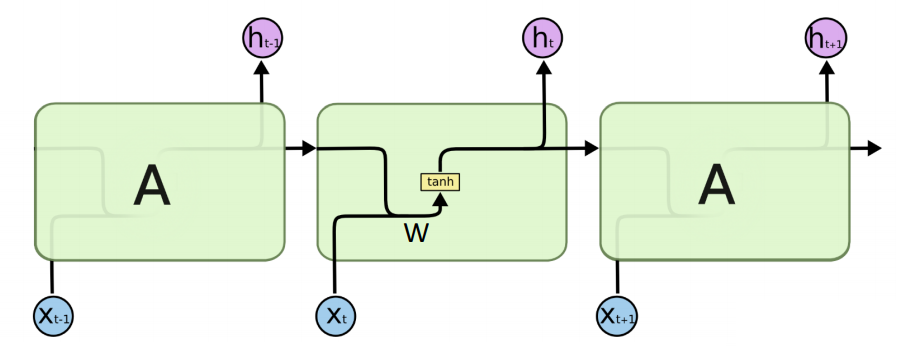

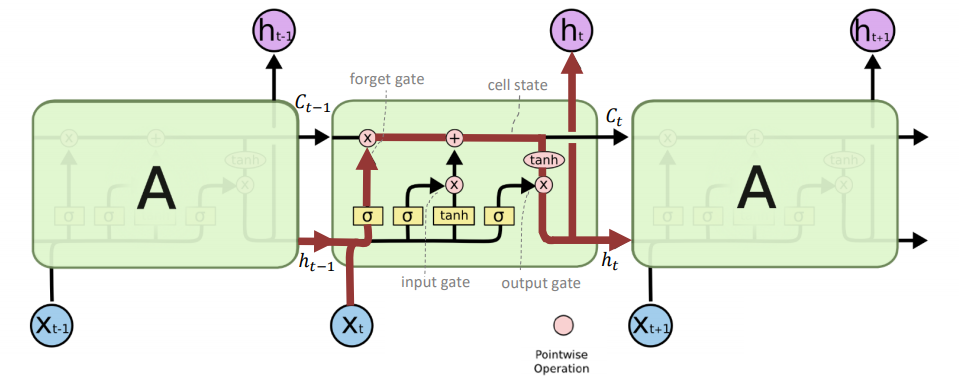

- RNN : There is only the simple operation connecting the recurrent layer. If the sequence length is long, it suffers from the problem of vanishing gradients during backpropagation.
- LSTM : A LSTM is composed of a cell, an input gate, an output gate and a forget gate. The cell state remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. The thick line is the same as the RNN's path. These additional elements help LSTM network prevent the gradient vanishing
    - Forget gate : Decide what information to throw away (or forget) from the "cell state"
    - Input gate : Decide what new information to store in the cell state
    - Output gate : Decide what to output through another gating


### **1-2. Import required libraries**

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os 
import torch.nn.functional as F

from tqdm import tqdm
import string
import random
import re
import time, math

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### **Embedding**

The largest application field for RNN/LSTM to learn sequntial information is NLP (Natural Language Processing)

Converting human-understandable text into machine-understandable number/vector is called **embedding**.

To put text data as input of the RNN, **we should vectorize the text data** utilizing embedding process.

+ 1) In character-level language modeling, a character is entered as an input of RNN, and for this, **character embedding** which vectorizes a character is required.
+ 2) In word-level language modeling, a word is entered as an input of RNN, and thus, **word embedding (or contextual embedding)** which vectorizes a word is required.

In today's practice session, we will proceed with a simple character-level language modeling.

### **1-3. Character embedding**

In order to put characters of the sentence as input of RNN, we should implement character embedding before entering the model as input. There are several embedding methods, but here we use a embedding method which makes one-hot vector.

- **Character Embedding**: Convert each character to embedding vector
- **string_to_onehot**: Convert string to one-hot vector
- **onehot_to_string**: Convert one-hot vector to character (string list)

In [ ]:
# Preprocessing string data
# alphabet(0-25), others(26~32), start(33) -> 34 chars

chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;0"
char_list = [i for i in chars]
char_len = len(char_list)
n_letters = len(char_list)

# String to one-hot vector
# a -> [1 0 0 ... 0 0], b -> [0 1 0 0 ... 0 0]

def string_to_onehot(string,seq_len=1):
    start = np.zeros(shape=len(char_list) ,dtype=int)
    end = np.zeros(shape=len(char_list) ,dtype=int)
    start[-1] = 1 # This is initial input

    # Insert zeros for initial input
    for i in range(seq_len):
        if i == 0:
            onehot = start
        else:
            onehot = np.vstack([start,onehot])

    # Convert string to one-hot vector
    for i in string:
        idx = char_list.index(i)
        zero = np.zeros(shape=char_len ,dtype=int)
        zero[idx]=1
        onehot = np.vstack([onehot,zero])
    
    return onehot

# Onehot vector to word
# [1 0 0 ... 0 0] -> a 

def onehot_to_word(onehot_1):
    out = ''
    for i in range(onehot_1.size(0)):
        onehot = torch.Tensor.numpy(onehot_1[i,:])
        out = out + char_list[onehot.argmax()]
    return out

In [ ]:
print("The total number of character :",char_len)

In [ ]:
string = 'ak'

# 1) String to one-hot vector
a_onehot = string_to_onehot(string,1)
print("The one-hot vector of \"a\" :\n",a_onehot) # The first element is the initial input "0".
print("The shape of one-hot vector of 'ak': ",np.shape(a_onehot))

In [ ]:
# 2) One-hot vector to string
a_vec=a_onehot[1:np.shape(a_onehot)[0],:]
a_string = onehot_to_word(torch.Tensor(a_vec))
print("The original string :", a_string)

## **Today's task**

Let's generate the following sentence by predicting the next character.

In [ ]:
string = "hello pytorch.how long can a rnn cell remember? show us your limit!"

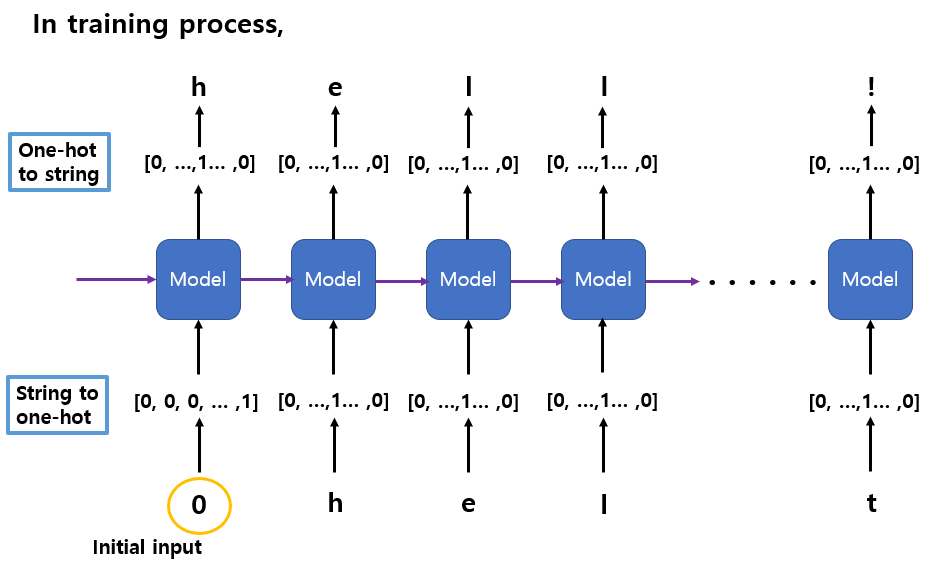

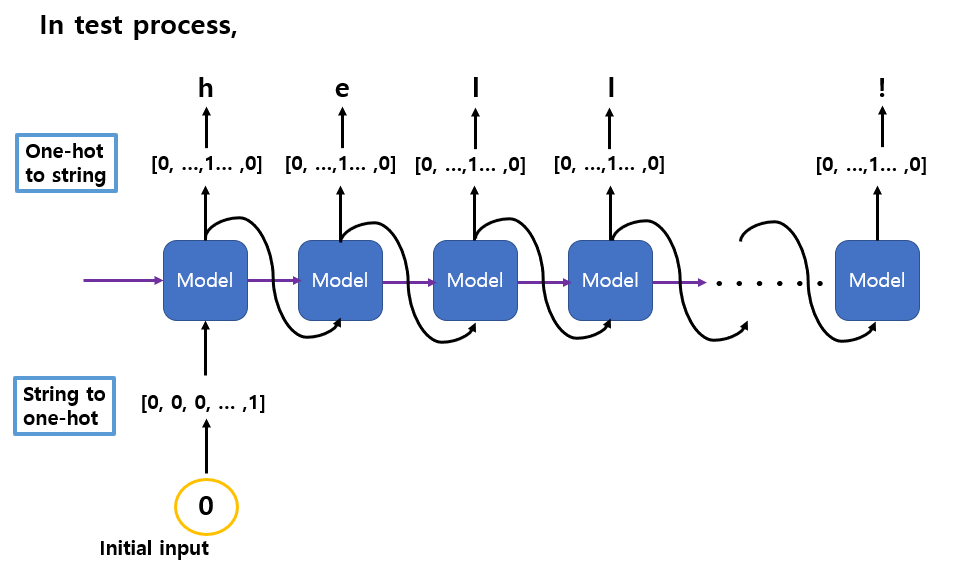

### Parameter settings

In [ ]:
input_size = char_len #length of embedding vector: 34
hidden_size = 50 # number of hidden neurons
output_size = input_size

lr = 0.01
epochs = 2000

### **1-4. Make a RNN model**

- We will implement a RNN model using nn.Linear layers
- As the time step progresses, $h_t$ and $y_t$ are created by $x_t$ and $h_{t-1}$. 
- When the input $x_t$ is $j^{th}$ character in the given sentence, the output $y_t$ should be $(j+1)^{th}$ character in the given sentence.
- But at this time, the parameters of the three linear layers are shared at all time steps (model weights are updated after learning whole sentence).


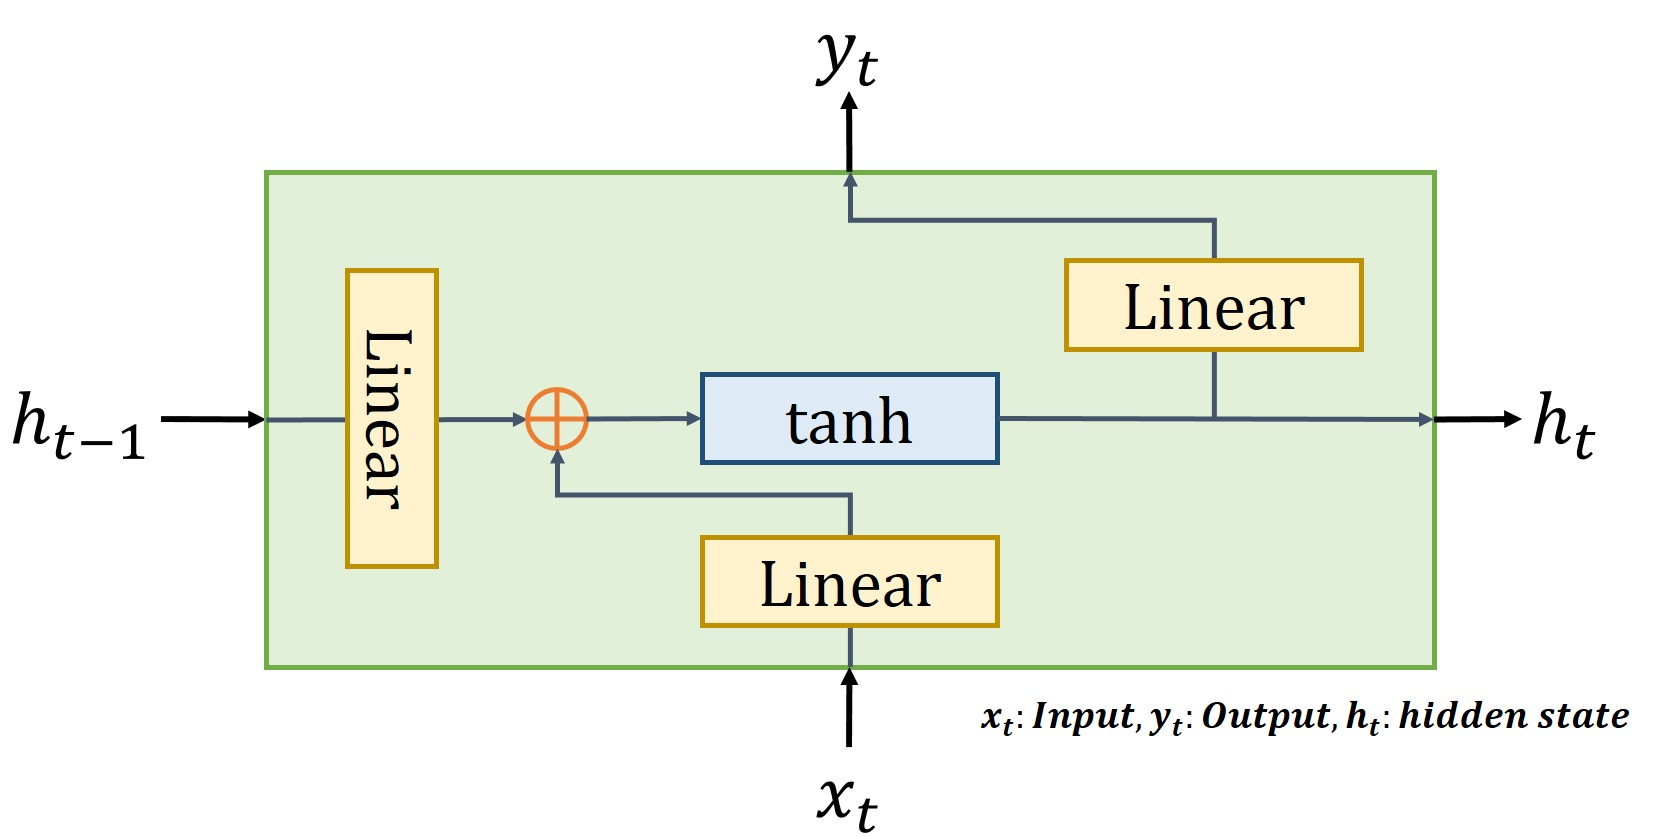

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.act_fn = nn.Tanh()
    
    def forward(self, input, hidden):
        ###################################### Write your code here ##########################################

        hidden =                                     # 1) update hidden (h_t) using input (x_t) and previous hidden (h_t-1)
        output =                                     # 2) obtain output (y_t) from hidden (h_t)

        ######################################################################################################
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  

### **1-5. Loss and optimizer**


In [ ]:
rnn = RNN(input_size,hidden_size,output_size) # Define the RNN model

loss_func = nn.MSELoss() 
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

### **1-6. Training process**

In [ ]:
one_hot = torch.from_numpy(string_to_onehot(string)).type_as(torch.FloatTensor()) #Convert the given sentence to one-hot vector

# Input of LSTM during training # Note that zero are inserted (since sequence length is 1)
print(onehot_to_word(one_hot))

In [ ]:
for i in range(epochs):
    rnn.zero_grad()
    total_loss = 0
    hidden = rnn.init_hidden()                                  # Initialize hidden state

    for j in range(len(string)):
        ###################################### Write your code here ##########################################

        input =                                                 # load x_t from one-hot
        output, hidden = rnn.forward(input, hidden)             # Predict y_t  # At all time step, the same weights of hidden state are shared
        target =                                                # load groundtruth of y_t from one-hot

        ######################################################################################################
        loss = loss_func(output.view(-1),target.view(-1))       # Compute loss at each time step
        total_loss += loss                                      # Accumulate the loss of each time step. Please refer to page 9 in week 13 lecture 

    total_loss.backward()                                       # Backpropagation for total loss
    optimizer.step()

    if i % 100 == 0:
        print('At {:4d}th epoch, Loss : {:0.4f}'.format(i, total_loss.item()))

#### **1-7. Test process**

In [ ]:
hidden = rnn.init_hidden()
input = one_hot[0:1,:] # Just put the initial input "0" as input of model
for i in range(len(string)):
    output, hidden = rnn.forward(input, hidden)
    
    output_target = output[-1].view(1,-1)
    print(onehot_to_word(output_target.data),end="")

    input = output_target # The output at previous time step becomes input at next time step.

##**Task 2 : Implement and train a LSTM model**

- We will implement LSTM model using pytorch nn.LSTM cell
- nn.LSTM cell uses input $x$ with shape (seq_len, batch_size, input_size) to produce output $y$ with shape (seq_len, batch_size, hidden_size).
- In this task, we will predict $y_t$ using inputs at multiple time steps (variable sequence length). For example, when sequence length is 3, we use $x_t, x_{t-1}, x_{t-2}$ to predict $y_t$.
- Variable "num_layers" refers to the depth of LSTM layers
- The details are as follows:

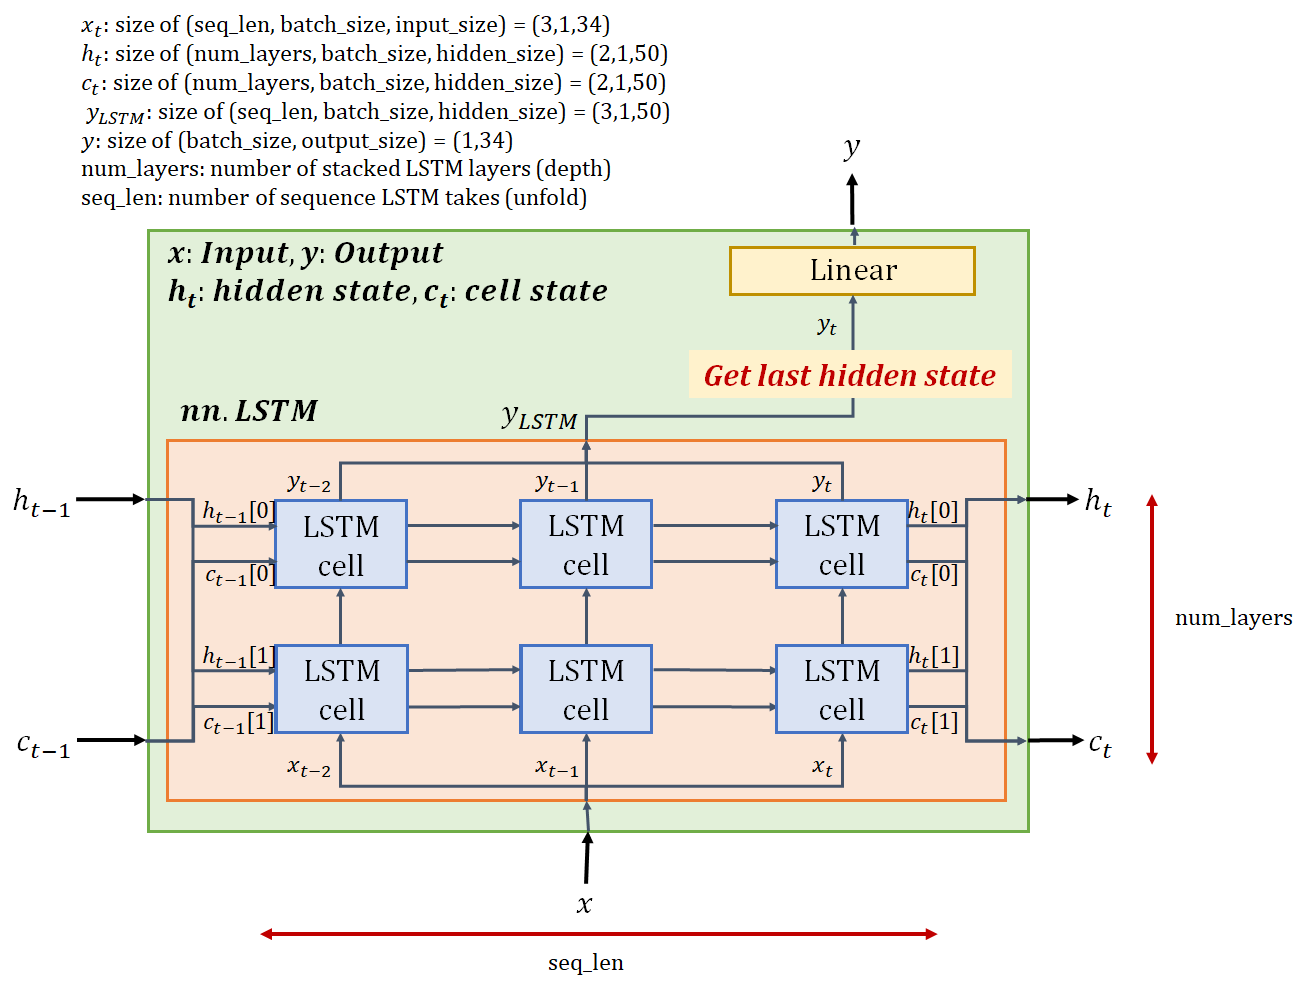

In [ ]:
# Recall the target problem

string = "hello pytorch. how long can a rnn cell remember? show me your limit!"
chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;0"
char_list = [i for i in chars]
char_len = len(char_list)
input_size = char_len
hidden_size = 50 
output_size = char_len

# Additional settings
batch_size = 1
num_layers = 2
seq_len = 3 # In this time, we use seq_len as 3.


lr = 0.01
num_epochs = 400

### **2-1. Make a LSTM model**

- In this task, we use `torch.nn.LSTM` class that calculates the operation of LSTM conveniently. When defining nn.LSTM, we need to input_size, hidden_size, num_layers, etc. There are more additional arguments available, see [here](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM)
- Since the output size of nn.LSTM cell is same as hidden size, we use additional linear layer to change output size same as embedding size (character length).

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,num_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers) # Use LSTM model in PyTorch
        self.h2o = nn.Linear(hidden_size, output_size) # Adjust to output size utilizing linear layer
        
    def forward(self,input,hidden,cell):
        ## nn.LSTM Input data shape: (seq_len, batch_size, input_size)
        ## nn.LSTM Output data shape: (seq_len, batch_size, hidden_size)
        
        output_LSTM,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.h2o(output_LSTM[-1,:,:]).reshape(batch_size,output_size) # Get last hidden state
        
        return output,hidden,cell
    
    def init_hidden_cell(self):
        hidden = torch.zeros(num_layers,batch_size,hidden_size)
        cell = torch.zeros(num_layers,batch_size,hidden_size)
        
        return hidden,cell

### **2-2. Loss and optimizer**

In [ ]:
lstm = LSTM(input_size,hidden_size,output_size,num_layers)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

### **2-3. Training process**

In [ ]:
one_hot = torch.from_numpy(string_to_onehot(string,seq_len)).type_as(torch.FloatTensor()) #Convert the given sentence to one-hot vector

# Input of LSTM during training # Note that 3 zeros are inserted (since sequence length is 3)
print(onehot_to_word(one_hot))

In [ ]:
for i in range(num_epochs):
    lstm.zero_grad()
    total_loss = 0
    hidden,cell = lstm.init_hidden_cell()
    
    for j in range(len(string)):
        ###################################### Write your code here ##########################################

        input_data =                                                # Load x_(t), x_(t+1), x_(t+2) and change the shape of input_data to (sequence length, batch size, input size)
        output, hidden, cell =                                      # Put the input and hidden state and cell state as input of lstm
        target =                                                    # Load groundtruth of y_(t+2) from one-hot and change the shape to (batch size, output size)
        loss =                                                      # Compute loss at each time step

        ######################################################################################################

        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i%100 ==0:
        print('At {:3d}th epoch, Loss : {:0.4f}'.format(i, total_loss.item()))

### **Test process**

In [ ]:
hidden,cell = lstm.init_hidden_cell()
input_data = one_hot[0:0+seq_len].view(seq_len,1,-1)

for j in range(len(string)):
    output, hidden, cell = lstm(input_data,hidden,cell)
    print(onehot_to_word(output.data),end="")
    input_data = torch.cat((input_data[1:,:,:],output.data.view(1,1,-1)),dim=0) # x_(t), x_(t+1), x_(t+2) -> x_(t+1), x_(t+2), y_(t+2)

## **Task 3: (Optional) Using pytorch nn.Embedding()**

- Besides one-hot vector embedding, we can use pytorch nn.Embedding for character embedding.
- nn.Embedding layer applies weights (as look-up table) to input(list of indices, integer type) to make corresponding embedding vectors.
- nn.Embedding layers are usually used for word embeddings
- nn.Embedding weights can be learned through training process.

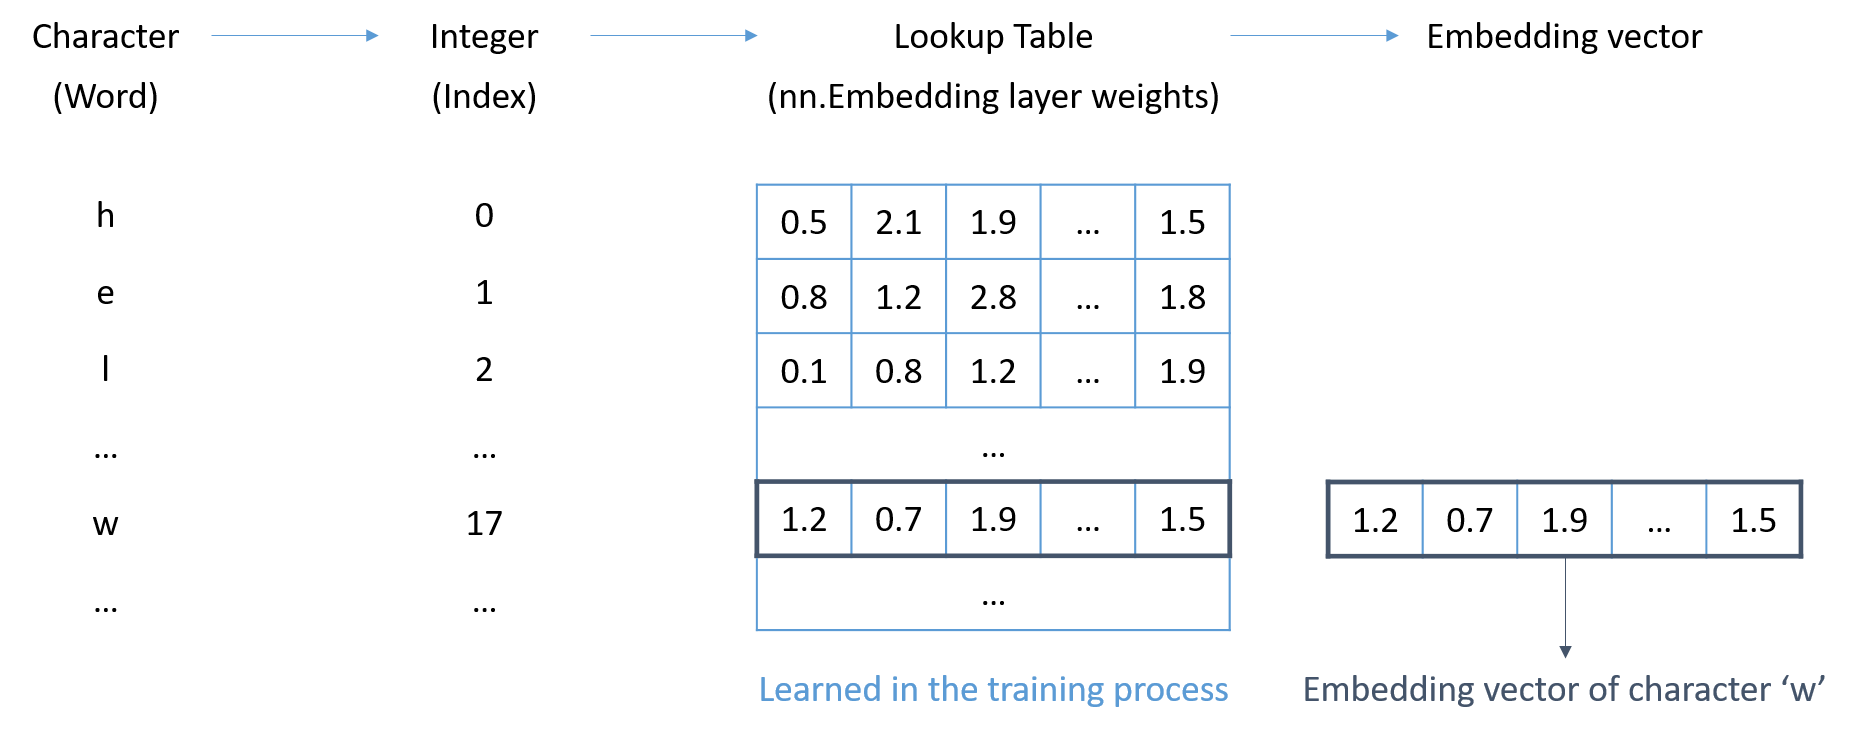

**Test nn.Embedding with printing the results**

- Let's see how the embedding layer works
- Input: shape (*), LongTensor of arbitrary shape containing the indices to extract
- Output: shape (*,H), where H is the embedding dimension

In [ ]:
embedder = nn.Embedding(num_embeddings=4,embedding_dim=5)
print('Embedding layer lookup table:')
print(embedder.weight)

a = torch.LongTensor([0,0,0,1])
b = torch.LongTensor([3])

a_ = torch.LongTensor([[0,0,0,1],[1,0,0,0],[0,1,0,0],[0,0,1,0]])
b_ = torch.LongTensor([3,0,1,2])

print('Shape of input/output:')
print(a.size(), b.size(), a_.size(), b_.size())
print(embedder(a).size(), embedder(b).size(), embedder(a_).size(), embedder(b_).size())

**LSTM model with embedding layer**
- We have to encode the sentence: number of embedding is length of string
- The string can be embedded with certain embedding dimension.
- Previously, we used embedding dimension as size of character list 34) to encode all characters as one hot vector.
- We will **reduce embedding dimension to 15**, since the trainable weights will find the better embedding space in the reduced dimension. 

In [ ]:
input_size = 15

class LSTM_emb(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,num_layers):
        super(LSTM_emb, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=len(string),embedding_dim=input_size)
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def forward(self,input,hidden,cell):
        input = self.embedding(input).view(seq_len,1,-1)
        output,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.h2o(output[-1,:])        
        return output,hidden,cell
    
    def init_hidden_cell(self):
        hidden = torch.zeros(num_layers,batch_size,hidden_size)
        cell = torch.zeros(num_layers,batch_size,hidden_size)
        
        return hidden,cell

- input/target are "index", so we use cross entropy loss.

In [ ]:
lstm_emb = LSTM_emb(input_size,hidden_size,output_size,num_layers)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_emb.parameters(), lr=lr)

**Input generation for embedding layer**
- To encode the data with embedding layer, the sentence should be injected as "index" of character list.

In [ ]:
def string_to_index(string,seq_len):
    input_as_index = np.zeros(len(string)+seq_len)
    for i in range(seq_len):
        if i == 0:
            input_as_index = np.array([char_list.index('0')])
        else:
            input_as_index = np.vstack([char_list.index('0'),input_as_index])
    for i in range(len(string)):
        input_as_index= np.append(input_as_index,char_list.index(string[i]))
    input_as_index = torch.LongTensor(input_as_index)

    return input_as_index

In [ ]:
input = string_to_index(string,seq_len)

for i in range(num_epochs):
    lstm_emb.zero_grad()
    total_loss = 0
    hidden,cell = lstm_emb.init_hidden_cell()
    
    for j in range(len(string)):
        input_data = input[j:j+seq_len].reshape(seq_len,1)
        output, hidden, cell = lstm_emb(input_data,hidden,cell)
        target = input[j+seq_len].view(-1)
        loss = loss_func(output,target)
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i%100 ==0:
        print('At {:3d}th epoch, Loss : {:0.4f}'.format(i, total_loss.item()))

In [ ]:
hidden,cell = lstm_emb.init_hidden_cell()
input_data = input[0:0+seq_len].view(seq_len,1)

for j in range(len(string)):
    output, hidden, cell = lstm_emb(input_data,hidden,cell)
    _, predicted = torch.max(output.data,dim=1)
    print(char_list[predicted],end="")
    input_data = torch.cat((input_data[1:,:],torch.LongTensor(predicted.view(-1,1))),dim=0)

## References

1) https://github.com/GunhoChoi/PyTorch-FastCampus/tree/master/05_RNN

2) https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

3) https://en.wikipedia.org/wiki/Long_short-term_memory